In [1]:
# Import necessary libraries
import tensorflow as tf
print("GPUs available:", tf.config.list_physical_devices('GPU'))

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, AveragePooling2D, Activation
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image parameters
img_height, img_width = 128, 128
batch_size = 32

train_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
).flow_from_directory(
    'All apples/Train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

valid_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input
).flow_from_directory(
    'All apples/Test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 5672 images belonging to 2 classes.
Found 1779 images belonging to 2 classes.


# Transfer Learning:ResNet

In [11]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(
    weights='imagenet',      # load weights pre-trained on ImageNet
    include_top=False,       # drop the ImageNet classifier head
    input_shape=(img_height, img_width, 3),
    pooling='avg'            # global average pooling on feature maps
)


2025-04-20 00:05:44.922817: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-04-20 00:05:44.922971: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-20 00:05:44.924091: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-20 00:05:44.924163: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-20 00:05:44.924408: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 56s 1us/step


In [12]:
base_model.trainable = False


In [21]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    base_model,
    # Fully connected layer
    Dense(128, activation=LeakyReLU(alpha=0.01)),
    Dropout(0.3),
    
    Dense(128, activation=LeakyReLU(alpha=0.01)),
    Dropout(0.3),
    
    Dense(64, activation=LeakyReLU(alpha=0.01)),
    Dropout(0.3),
    
    Dense(64, activation=LeakyReLU(alpha=0.01)),
    Dropout(0.3),
    
    # Output layer: number of neurons equals number of classes
    Dense(train_gen.num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model's architecture
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,879,042 (91.09 MB)

 Trainable params: 291,330 (1.11 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [23]:
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    validation_data=valid_gen,
    validation_steps=valid_gen.samples // batch_size,
    epochs=20
)


/Users/milind/anaconda3/envs/gpu_env/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


2025-04-20 00:10:41.180574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8485 - loss: 0.3456

/Users/milind/anaconda3/envs/gpu_env/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


177/177 ━━━━━━━━━━━━━━━━━━━━ 32s 147ms/step - accuracy: 0.8489 - loss: 0.3448 - val_accuracy: 0.9852 - val_loss: 0.0422
Epoch 2/20
  1/177 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9688 - loss: 0.0351

/Users/milind/anaconda3/envs/gpu_env/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9688 - loss: 0.0351 - val_accuracy: 0.9852 - val_loss: 0.0425
Epoch 3/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 23s 130ms/step - accuracy: 0.9707 - loss: 0.0778 - val_accuracy: 0.9864 - val_loss: 0.0341
Epoch 4/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9852 - val_loss: 0.0346
Epoch 5/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 23s 132ms/step - accuracy: 0.9829 - loss: 0.0510 - val_accuracy: 0.9886 - val_loss: 0.0358
Epoch 6/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 1.0000 - loss: 0.0249 - val_accuracy: 0.9886 - val_loss: 0.0351
Epoch 7/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 23s 130ms/step - accuracy: 0.9852 - loss: 0.0396 - val_accuracy: 0.9943 - val_loss: 0.0194
Epoch 8/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 1.0000 - loss: 0.0101 - val_accuracy: 0.9949 - val_loss: 0.0201
Epoch 9/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 23s 130ms/step - accuracy: 0.9825 - loss: 0.0516 - val_accurac

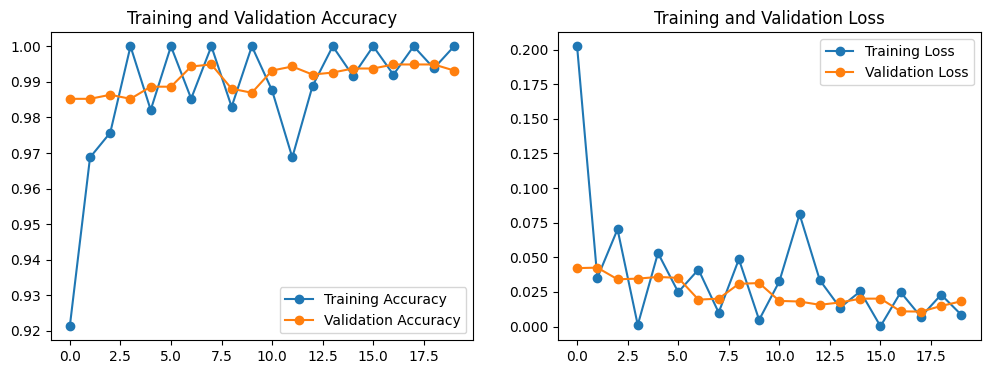

56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.9926 - loss: 0.0198
Test Accuracy: 99.33%
Test loss: 1.81%


In [28]:
# Plot training & validation accuracy and loss values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model
loss1, accuracy1 = model.evaluate(valid_gen)
print(f'Test Accuracy: {accuracy1 * 100:.2f}%')
print(f'Test loss: {loss1 * 100:.2f}%')

In [116]:
from sklearn.metrics import classification_report
import numpy as np

# Generate predictions
y_pred_probs = model.predict(valid_gen)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = valid_gen.classes  # True labels

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=valid_gen.class_indices.keys()))


248/248 ━━━━━━━━━━━━━━━━━━━━ 61s 239ms/step
                precision    recall  f1-score   support

   freshapples       0.10      0.10      0.10       791
   freshbanana       0.10      0.10      0.10       892
 freshcucumber       0.04      0.05      0.05       279
     freshokra       0.04      0.05      0.05       370
  freshoranges       0.06      0.06      0.06       388
   freshpatato       0.05      0.04      0.04       487
    freshtamto       0.08      0.09      0.08       679
  rottenapples       0.14      0.15      0.14       988
  rottenbanana       0.12      0.12      0.12       900
rottencucumber       0.04      0.05      0.05       255
    rottenokra       0.00      0.00      0.00       224
 rottenoranges       0.05      0.05      0.05       403
  rottenpatato       0.08      0.10      0.09       630
   rottentamto       0.07      0.06      0.06       641

      accuracy                           0.09      7927
     macro avg       0.07      0.07      0.07      7927
  

In [52]:
model.save('apple_ResNet.keras')

In [5]:
from tensorflow.keras.models import load_model
Res_model=load_model(
    'apple_ResNet.keras',
    custom_objects={"LeakyReLU": LeakyReLU},
    compile=False
)
Res_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

2025-04-20 10:52:59.987786: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-04-20 10:52:59.988032: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-20 10:52:59.988049: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-20 10:52:59.988567: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-20 10:52:59.988591: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [21]:
history = Res_model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    validation_data=valid_gen,
    validation_steps=valid_gen.samples // batch_size,
    epochs=10
)

Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.9880 - loss: 0.0396

/Users/milind/anaconda3/envs/gpu_env/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


177/177 ━━━━━━━━━━━━━━━━━━━━ 74s 418ms/step - accuracy: 0.9880 - loss: 0.0396 - val_accuracy: 0.9943 - val_loss: 0.0139
Epoch 2/10
  1/177 ━━━━━━━━━━━━━━━━━━━━ 1:13 415ms/step - accuracy: 1.0000 - loss: 0.0145

/Users/milind/anaconda3/envs/gpu_env/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


177/177 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - accuracy: 1.0000 - loss: 0.0145 - val_accuracy: 0.9949 - val_loss: 0.0153
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 85s 481ms/step - accuracy: 0.9926 - loss: 0.0276 - val_accuracy: 0.9926 - val_loss: 0.0216
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 1.0000 - loss: 8.2513e-04 - val_accuracy: 0.9903 - val_loss: 0.0236
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 67s 379ms/step - accuracy: 0.9935 - loss: 0.0217 - val_accuracy: 0.9926 - val_loss: 0.0169
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 1.0000 - loss: 4.6784e-04 - val_accuracy: 0.9915 - val_loss: 0.0197
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 68s 383ms/step - accuracy: 0.9883 - loss: 0.0325 - val_accuracy: 0.9966 - val_loss: 0.0112
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 1.0000 - loss: 6.5058e-05 - val_accuracy: 0.9966 - val_loss: 0.0111
Epoch 9/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 65s 365ms/step - accuracy: 0.9931 - loss: 0.0

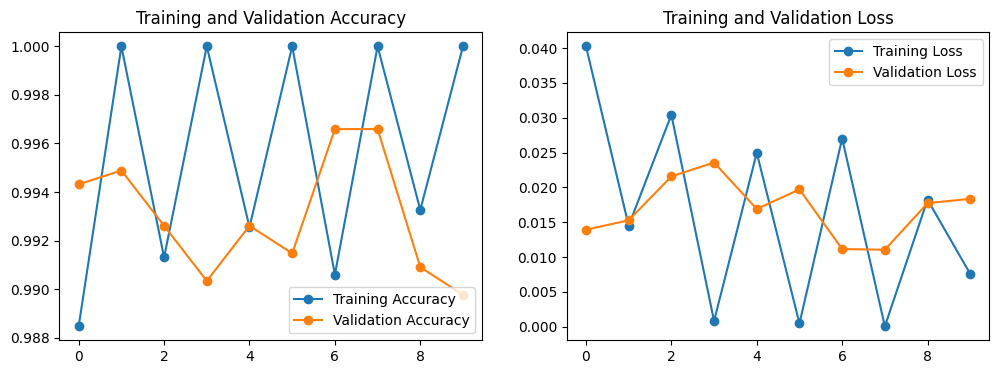

56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 240ms/step - accuracy: 0.9913 - loss: 0.0186
Test Accuracy: 98.99%
Test loss: 1.82%


In [25]:
# Plot training & validation accuracy and loss values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model
loss1, accuracy1 = Res_model.evaluate(valid_gen)
print(f'Test Accuracy: {accuracy1 * 100:.2f}%')
print(f'Test loss: {loss1 * 100:.2f}%')

In [27]:
history = Res_model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    validation_data=valid_gen,
    validation_steps=valid_gen.samples // batch_size,
    epochs=10
)

Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 59s 336ms/step - accuracy: 0.9963 - loss: 0.0140 - val_accuracy: 0.9915 - val_loss: 0.0196
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.9688 - loss: 0.0505 - val_accuracy: 0.9903 - val_loss: 0.0205
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 75s 425ms/step - accuracy: 0.9929 - loss: 0.0182 - val_accuracy: 0.9932 - val_loss: 0.0172
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 1.0000 - loss: 0.0102 - val_accuracy: 0.9932 - val_loss: 0.0161
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 77s 438ms/step - accuracy: 0.9953 - loss: 0.0145 - val_accuracy: 0.9955 - val_loss: 0.0159
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 1.0000 - loss: 1.8707e-04 - val_accuracy: 0.9955 - val_loss: 0.0163
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 78s 439ms/step - accuracy: 0.9948 - loss: 0.0202 - val_accuracy: 0.9966 - val_loss: 0.0093
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 1.0000 - loss: 5

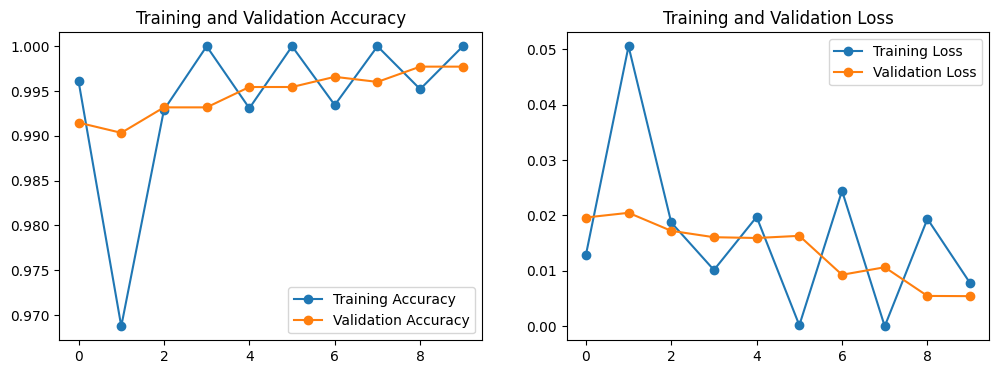

56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 236ms/step - accuracy: 0.9965 - loss: 0.0062
Test Accuracy: 99.78%
Test loss: 0.54%


In [28]:
# Plot training & validation accuracy and loss values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model
loss1, accuracy1 = Res_model.evaluate(valid_gen)
print(f'Test Accuracy: {accuracy1 * 100:.2f}%')
print(f'Test loss: {loss1 * 100:.2f}%')

In [31]:
history = Res_model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    validation_data=valid_gen,
    validation_steps=valid_gen.samples // batch_size,
    epochs=10
)

Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 92s 519ms/step - accuracy: 0.9962 - loss: 0.0129 - val_accuracy: 0.9949 - val_loss: 0.0143
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 19s 106ms/step - accuracy: 1.0000 - loss: 0.0173 - val_accuracy: 0.9949 - val_loss: 0.0141
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 111s 625ms/step - accuracy: 0.9908 - loss: 0.0259 - val_accuracy: 0.9977 - val_loss: 0.0066
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 1.0000 - loss: 1.3784e-07 - val_accuracy: 0.9977 - val_loss: 0.0066
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 104s 588ms/step - accuracy: 0.9942 - loss: 0.0202 - val_accuracy: 0.9983 - val_loss: 0.0085
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 16s 87ms/step - accuracy: 1.0000 - loss: 0.0207 - val_accuracy: 0.9977 - val_loss: 0.0083
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 105s 595ms/step - accuracy: 0.9961 - loss: 0.0123 - val_accuracy: 0.9989 - val_loss: 0.0059
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - accuracy: 1.0000 - lo

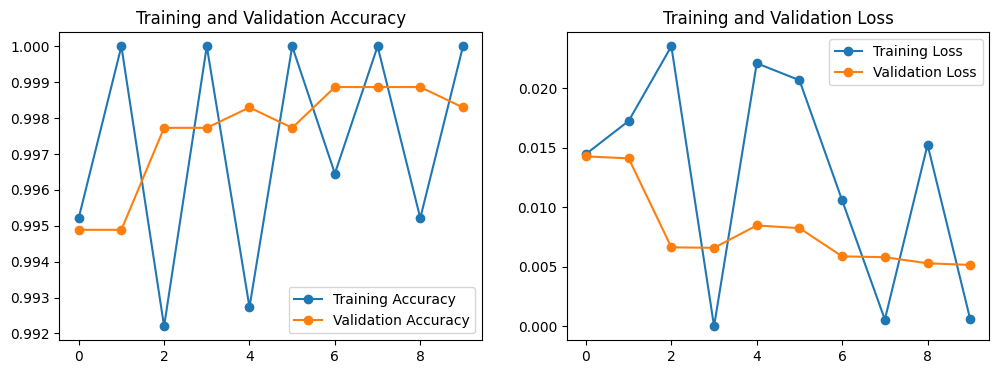

56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.9979 - loss: 0.0056
Test Accuracy: 99.83%
Test loss: 0.51%


In [32]:
# Plot training & validation accuracy and loss values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model
loss1, accuracy1 = Res_model.evaluate(valid_gen)
print(f'Test Accuracy: {accuracy1 * 100:.2f}%')
print(f'Test loss: {loss1 * 100:.2f}%')

In [37]:
# Evaluate the model
loss1, accuracy1 = Res_model.evaluate(valid_gen)
print(f'Test Accuracy: {accuracy1 * 100:.2f}%')
print(f'Test loss: {loss1:.2f}')

56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.9988 - loss: 0.0039
Test Accuracy: 99.83%
Test loss: 0.01


In [47]:
Res_model.save('Res_Apple_50.keras')

# Complete Dataset

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image parameters
img_height, img_width = 128, 128
batch_size = 32

train_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
).flow_from_directory(
    'dataset/Train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

valid_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input
).flow_from_directory(
    'dataset/Test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 22233 images belonging to 14 classes.
Found 7927 images belonging to 14 classes.


### Transfer Learning:ResNet

In [54]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(
    weights='imagenet',      # load weights pre-trained on ImageNet
    include_top=False,       # drop the ImageNet classifier head
    input_shape=(img_height, img_width, 3),
    pooling='avg'            # global average pooling on feature maps
)
base_model.trainable = False

In [56]:
model = Sequential([
    base_model,
    # Fully connected layer
    Dense(128, activation=LeakyReLU(alpha=0.01)),
    Dropout(0.3),
    
    Dense(128, activation=LeakyReLU(alpha=0.01)),
    Dropout(0.3),
    
    Dense(64, activation=LeakyReLU(alpha=0.01)),
    Dropout(0.3),
    
    Dense(64, activation=LeakyReLU(alpha=0.01)),
    Dropout(0.3),
    
    # Output layer: number of neurons equals number of classes
    Dense(train_gen.num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model's architecture
model.summary()

/Users/milind/anaconda3/envs/gpu_env/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 14)             │           910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,879,822 (91.09 MB)

 Trainable params: 292,110 (1.11 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [62]:
# Define Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    min_delta=0.01,
    patience=15,           # Stop if no improvement after 10 epochs
    restore_best_weights=True,  # Restore model with best weights
    verbose=1
)

In [66]:
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    validation_data=valid_gen,
    validation_steps=valid_gen.samples // batch_size,
    epochs=20,
    callbacks=[early_stopping]
)


Epoch 1/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 292s 412ms/step - accuracy: 0.5455 - loss: 1.4113 - val_accuracy: 0.8621 - val_loss: 0.4125
Epoch 2/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 67s 97ms/step - accuracy: 0.8438 - loss: 0.4623 - val_accuracy: 0.8597 - val_loss: 0.4111
Epoch 3/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 275s 396ms/step - accuracy: 0.8465 - loss: 0.4525 - val_accuracy: 0.8703 - val_loss: 0.3147
Epoch 4/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 56s 81ms/step - accuracy: 0.8438 - loss: 0.2721 - val_accuracy: 0.8698 - val_loss: 0.3130
Epoch 5/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 312s 450ms/step - accuracy: 0.8833 - loss: 0.3446 - val_accuracy: 0.8797 - val_loss: 0.3509
Epoch 6/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 73s 104ms/step - accuracy: 0.8125 - loss: 0.3986 - val_accuracy: 0.8821 - val_loss: 0.3474
Epoch 7/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 274s 394ms/step - accuracy: 0.8896 - loss: 0.3095 - val_accuracy: 0.9009 - val_loss: 0.2487
Epoch 8/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 65s 93ms/step - accuracy: 0.8750 - loss: 

In [70]:
# Evaluate the model
loss1, accuracy1 = model.evaluate(valid_gen)
print(f'Test Accuracy: {accuracy1 * 100:.2f}%')
print(f'Test loss: {loss1:.2f}')

248/248 ━━━━━━━━━━━━━━━━━━━━ 64s 258ms/step - accuracy: 0.9198 - loss: 0.2077
Test Accuracy: 92.20%
Test loss: 0.19


In [72]:
model.save('Res_dataset_20.keras')

# HERE

## 20 more epochs 

In [118]:
from tensorflow.keras.models import load_model
model = load_model(
    'Res_dataset_20.keras',
    custom_objects={"LeakyReLU": LeakyReLU},
    compile=False
)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [121]:
# Evaluate the model
loss1, accuracy1 = model.evaluate(valid_gen)
print(f'Test Accuracy: {accuracy1 * 100:.2f}%')
print(f'Test loss: {loss1:.2f}')

248/248 ━━━━━━━━━━━━━━━━━━━━ 67s 254ms/step - accuracy: 0.9225 - loss: 0.1889
Test Accuracy: 92.20%
Test loss: 0.19


In [124]:
# Define Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    min_delta=0.01,
    patience=15,           # Stop if no improvement after 10 epochs
    restore_best_weights=True,  # Restore model with best weights
    verbose=1
)

history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    validation_data=valid_gen,
    validation_steps=valid_gen.samples // batch_size,
    epochs=20,
    callbacks=[early_stopping]
)

/Users/milind/anaconda3/envs/gpu_env/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 291s 410ms/step - accuracy: 0.9287 - loss: 0.2154 - val_accuracy: 0.9361 - val_loss: 0.1837
Epoch 2/20
  1/694 ━━━━━━━━━━━━━━━━━━━━ 2:40 231ms/step - accuracy: 0.9688 - loss: 0.1228

/Users/milind/anaconda3/envs/gpu_env/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


694/694 ━━━━━━━━━━━━━━━━━━━━ 62s 89ms/step - accuracy: 0.9688 - loss: 0.1228 - val_accuracy: 0.9365 - val_loss: 0.1821
Epoch 3/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 286s 412ms/step - accuracy: 0.9340 - loss: 0.1926 - val_accuracy: 0.9395 - val_loss: 0.1838
Epoch 4/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 51s 73ms/step - accuracy: 1.0000 - loss: 0.0698 - val_accuracy: 0.9397 - val_loss: 0.1789
Epoch 5/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 291s 420ms/step - accuracy: 0.9391 - loss: 0.1834 - val_accuracy: 0.9414 - val_loss: 0.2029
Epoch 6/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 67s 96ms/step - accuracy: 1.0000 - loss: 0.1096 - val_accuracy: 0.9414 - val_loss: 0.2059
Epoch 7/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 377s 543ms/step - accuracy: 0.9407 - loss: 0.1795 - val_accuracy: 0.9519 - val_loss: 0.1443
Epoch 8/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 106s 153ms/step - accuracy: 0.9688 - loss: 0.0745 - val_accuracy: 0.9523 - val_loss: 0.1433
Epoch 9/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 378s 545ms/step - accuracy: 0.9486 - loss: 0.1641 - v

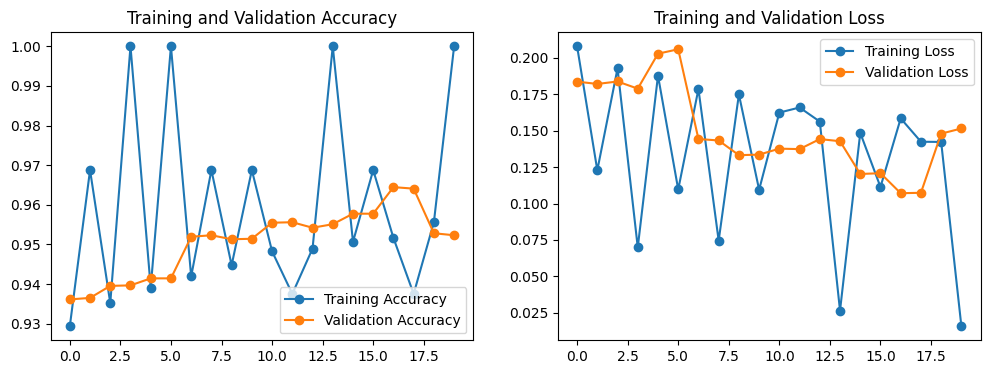

248/248 ━━━━━━━━━━━━━━━━━━━━ 65s 260ms/step - accuracy: 0.9645 - loss: 0.1098
Test Accuracy: 96.46%
Test loss: 0.11


In [125]:
# Plot training & validation accuracy and loss values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model
loss1, accuracy1 = model.evaluate(valid_gen)
print(f'Test Accuracy: {accuracy1 * 100:.2f}%')
print(f'Test loss: {loss1:.2f}')

In [128]:
model.save('Res_dataset_40.keras')

## 20 more epochs

In [131]:
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    validation_data=valid_gen,
    validation_steps=valid_gen.samples // batch_size,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 289s 417ms/step - accuracy: 0.9514 - loss: 0.1526 - val_accuracy: 0.9567 - val_loss: 0.1276
Epoch 2/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 56s 80ms/step - accuracy: 0.9688 - loss: 0.1872 - val_accuracy: 0.9586 - val_loss: 0.1264
Epoch 3/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 117s 169ms/step - accuracy: 0.9560 - loss: 0.1492 - val_accuracy: 0.9624 - val_loss: 0.1111
Epoch 4/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 1.0000 - loss: 0.0329 - val_accuracy: 0.9620 - val_loss: 0.1109
Epoch 5/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 100s 144ms/step - accuracy: 0.9546 - loss: 0.1422 - val_accuracy: 0.9633 - val_loss: 0.1267
Epoch 6/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.9688 - loss: 0.1391 - val_accuracy: 0.9629 - val_loss: 0.1271
Epoch 7/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 108s 155ms/step - accuracy: 0.9565 - loss: 0.1449 - val_accuracy: 0.9567 - val_loss: 0.1229
Epoch 8/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 1.0000 - loss: 0

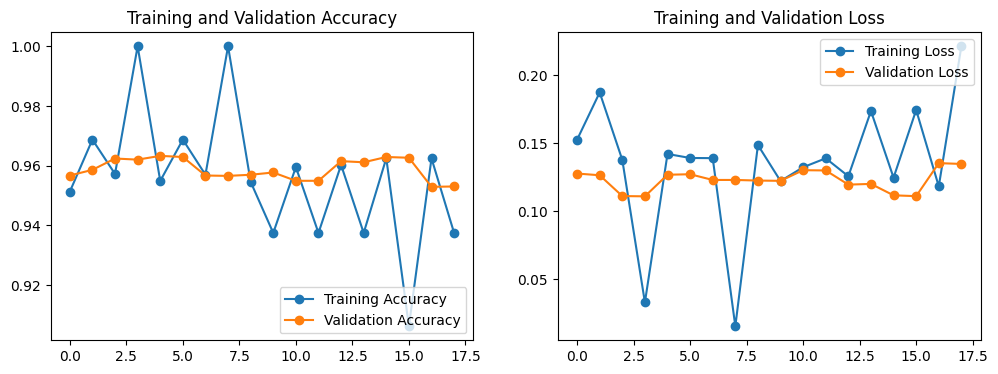

248/248 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.9612 - loss: 0.1147
Test Accuracy: 96.24%
Test loss: 0.11


In [132]:
# Plot training & validation accuracy and loss values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model
loss1, accuracy1 = model.evaluate(valid_gen)
print(f'Test Accuracy: {accuracy1 * 100:.2f}%')
print(f'Test loss: {loss1:.2f}')

In [133]:
model.save('Res_dataset_60.keras')

In [137]:
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    validation_data=valid_gen,
    validation_steps=valid_gen.samples // batch_size,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 103s 145ms/step - accuracy: 0.9554 - loss: 0.1424 - val_accuracy: 0.9628 - val_loss: 0.1180
Epoch 2/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.9062 - loss: 0.1978 - val_accuracy: 0.9629 - val_loss: 0.1179
Epoch 3/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 96s 139ms/step - accuracy: 0.9572 - loss: 0.1388 - val_accuracy: 0.9627 - val_loss: 0.1145
Epoch 4/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 1.0000 - loss: 0.0250 - val_accuracy: 0.9628 - val_loss: 0.1143
Epoch 5/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 101s 146ms/step - accuracy: 0.9600 - loss: 0.1320 - val_accuracy: 0.9613 - val_loss: 0.1116
Epoch 6/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 1.0000 - loss: 0.0462 - val_accuracy: 0.9618 - val_loss: 0.1115
Epoch 7/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 106s 153ms/step - accuracy: 0.9592 - loss: 0.1308 - val_accuracy: 0.9496 - val_loss: 0.1465
Epoch 8/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.9062 - loss: 0.

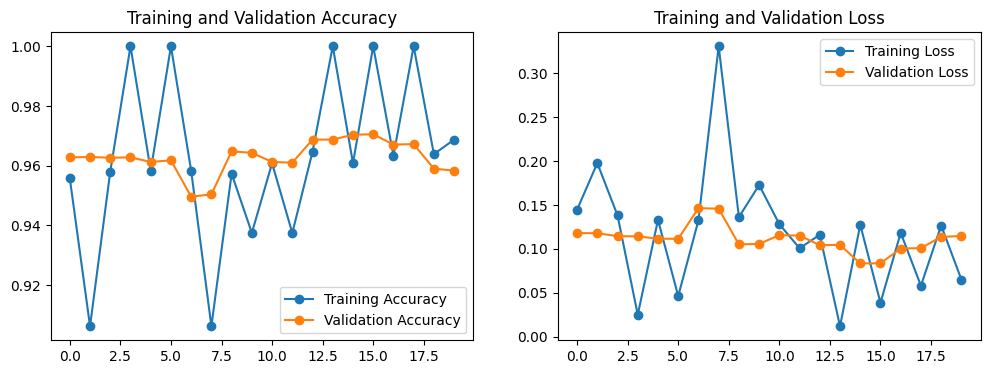

248/248 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.9739 - loss: 0.0764
Test Accuracy: 97.04%
Test loss: 0.08


In [138]:
# Plot training & validation accuracy and loss values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model
loss1, accuracy1 = model.evaluate(valid_gen)
print(f'Test Accuracy: {accuracy1 * 100:.2f}%')
print(f'Test loss: {loss1:.2f}')

In [139]:
model.save('Res_dataset_80.keras')

In [145]:
# validation_generator_all = validation_datagen.flow_from_directory(
#     'dataset/Test',
#     target_size=(img_width, img_height),
#     batch_size=batch_size,
#     class_mode='categorical',
#     shuffle=False
# )
validation_generator_all = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input
).flow_from_directory(
    'dataset/Test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)    
from sklearn.metrics import classification_report
import numpy as np

# Generate predictions
y_pred_probs = model.predict(validation_generator_all)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = validation_generator_all.classes  # True labels

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=list(validation_generator_all.class_indices.keys())))


Found 7927 images belonging to 14 classes.
248/248 ━━━━━━━━━━━━━━━━━━━━ 24s 92ms/step
                precision    recall  f1-score   support

   freshapples       1.00      0.99      1.00       791
   freshbanana       1.00      1.00      1.00       892
 freshcucumber       0.93      0.83      0.88       279
     freshokra       0.88      0.96      0.92       370
  freshoranges       0.99      0.97      0.98       388
   freshpatato       0.99      0.89      0.94       487
    freshtamto       1.00      1.00      1.00       679
  rottenapples       0.99      1.00      0.99       988
  rottenbanana       1.00      1.00      1.00       900
rottencucumber       0.80      0.86      0.83       255
    rottenokra       0.90      0.74      0.81       224
 rottenoranges       0.98      1.00      0.99       403
  rottenpatato       0.90      1.00      0.95       630
   rottentamto       1.00      1.00      1.00       641

      accuracy                           0.97      7927
     macro avg  

In [147]:
# Evaluate the model
loss1, accuracy1 = model.evaluate(valid_gen)
print(f'Test Accuracy: {accuracy1 * 100:.2f}%')
print(f'Test loss: {loss1:.2f}')

/Users/milind/anaconda3/envs/gpu_env/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


248/248 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - accuracy: 0.9753 - loss: 0.0690
Test Accuracy: 97.04%
Test loss: 0.08


Found 7927 images belonging to 14 classes.
248/248 ━━━━━━━━━━━━━━━━━━━━ 23s 87ms/step


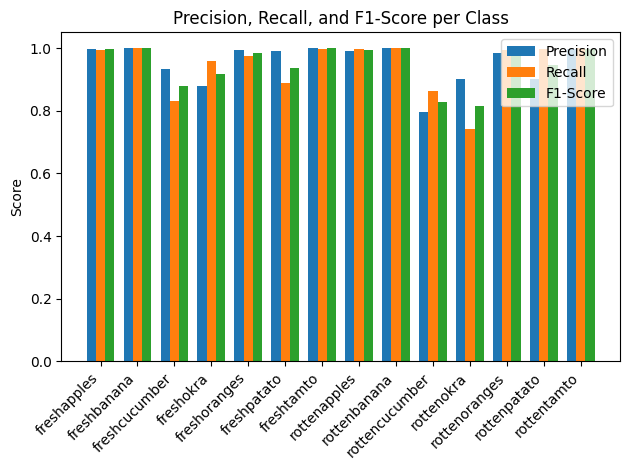

In [149]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

validation_generator_all = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input
).flow_from_directory(
    'dataset/Test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)    

# Generate predictions
y_pred_probs = model.predict(validation_generator_all)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = validation_generator_all.classes  # True labels

target_names = list(validation_generator_all.class_indices.keys())

report = classification_report(
    y_true, 
    y_pred_classes, 
    target_names=target_names, 
    output_dict=True
)

# --- Extract metrics ---
precision = [report[c]['precision'] for c in target_names]
recall    = [report[c]['recall']    for c in target_names]
f1        = [report[c]['f1-score']  for c in target_names]

# --- Plot grouped bar chart ---
x = np.arange(len(target_names))
width = 0.25

fig, ax = plt.subplots()
ax.bar(x - width, precision, width, label='Precision')
ax.bar(x,       recall,    width, label='Recall')
ax.bar(x + width, f1,      width, label='F1-Score')

ax.set_xticks(x)
ax.set_xticklabels(target_names, rotation=45, ha='right')
ax.set_ylabel('Score')
ax.set_title('Precision, Recall, and F1-Score per Class')
ax.legend()

plt.tight_layout()
plt.show()


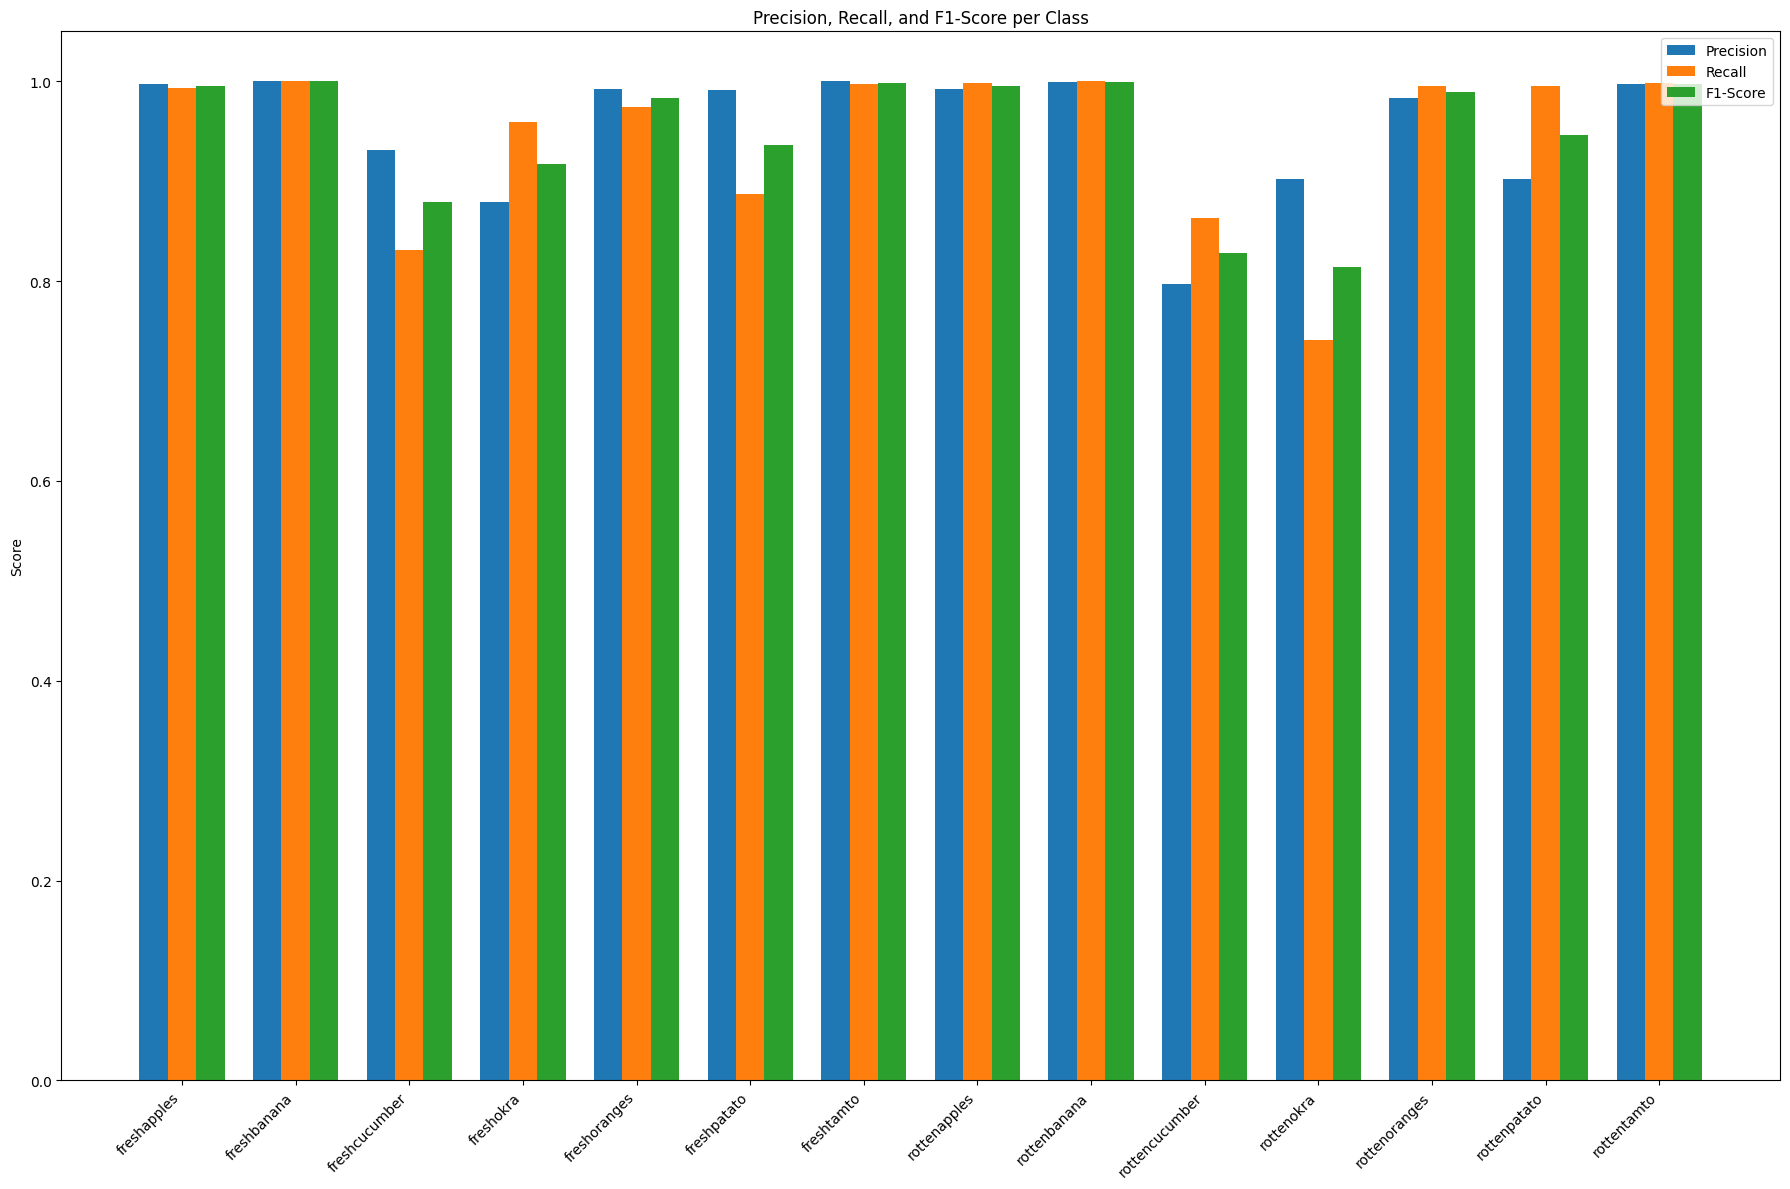

In [169]:
# --- Plot grouped bar chart ---
x = np.arange(len(target_names))
width = 0.25

fig, ax = plt.subplots(figsize=(18, 12))
ax.bar(x - width, precision, width, label='Precision')
ax.bar(x,       recall,    width, label='Recall')
ax.bar(x + width, f1,      width, label='F1-Score')

ax.set_xticks(x)
ax.set_xticklabels(target_names, rotation=45, ha='right')
ax.set_ylabel('Score')
ax.set_title('Precision, Recall, and F1-Score per Class')
ax.legend()

plt.tight_layout()
plt.show()

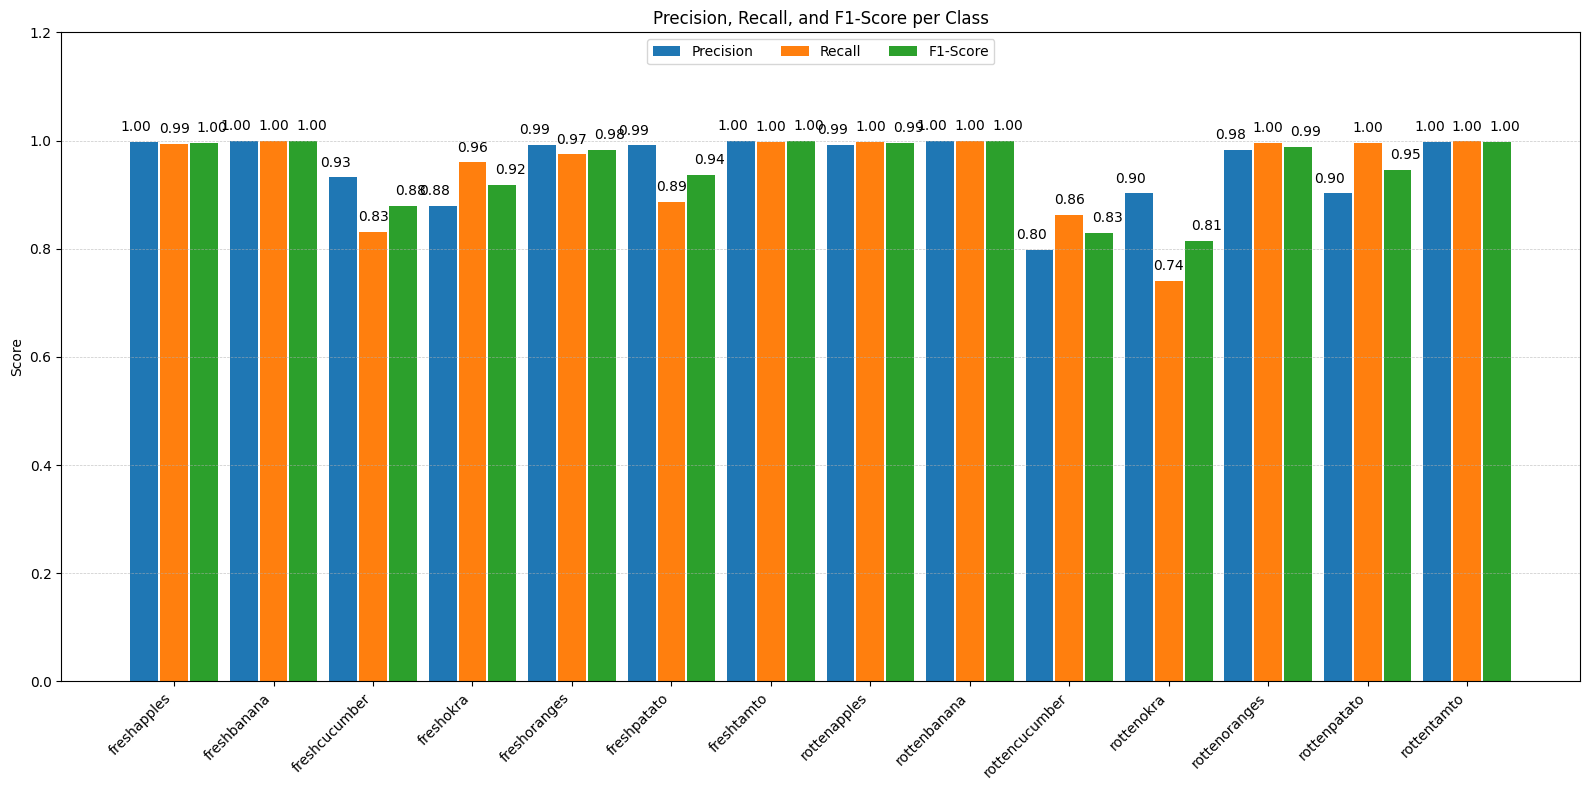

In [229]:
# --- Plot setup ---
x = np.arange(len(target_names)) 
width = 0.28

fig, ax = plt.subplots(figsize=(16, 8))         # wider figure
ax.bar(x - width - 0.02, precision, width, label='Precision')
ax.bar(x ,       recall,    width, label='Recall')
ax.bar(x + width + 0.02, f1,      width, label='F1-Score')

# --- Background grid lines on y-axis ---
ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# --- Labels, ticks, legend ---
ax.set_xticks(x)
ax.set_xticklabels(target_names, rotation=45, ha='right')
ax.set_ylabel('Score')
ax.set_ylim(0, 1.2)  # ensure space above 1.0 for annotations
ax.set_title('Precision, Recall, and F1-Score per Class')
ax.legend(loc='upper center', ncol=3)

# --- Annotate each bar with its value ---
for idx in x:
    ax.text(idx - width - 0.1, precision[idx] + 0.02, f"{precision[idx]:.2f}", ha='center')
    ax.text(idx,       recall[idx]    + 0.02, f"{recall[idx]:.2f}",    ha='center')
    ax.text(idx + width + 0.1, f1[idx]       + 0.02, f"{f1[idx]:.2f}",       ha='center')

plt.tight_layout()
plt.show()

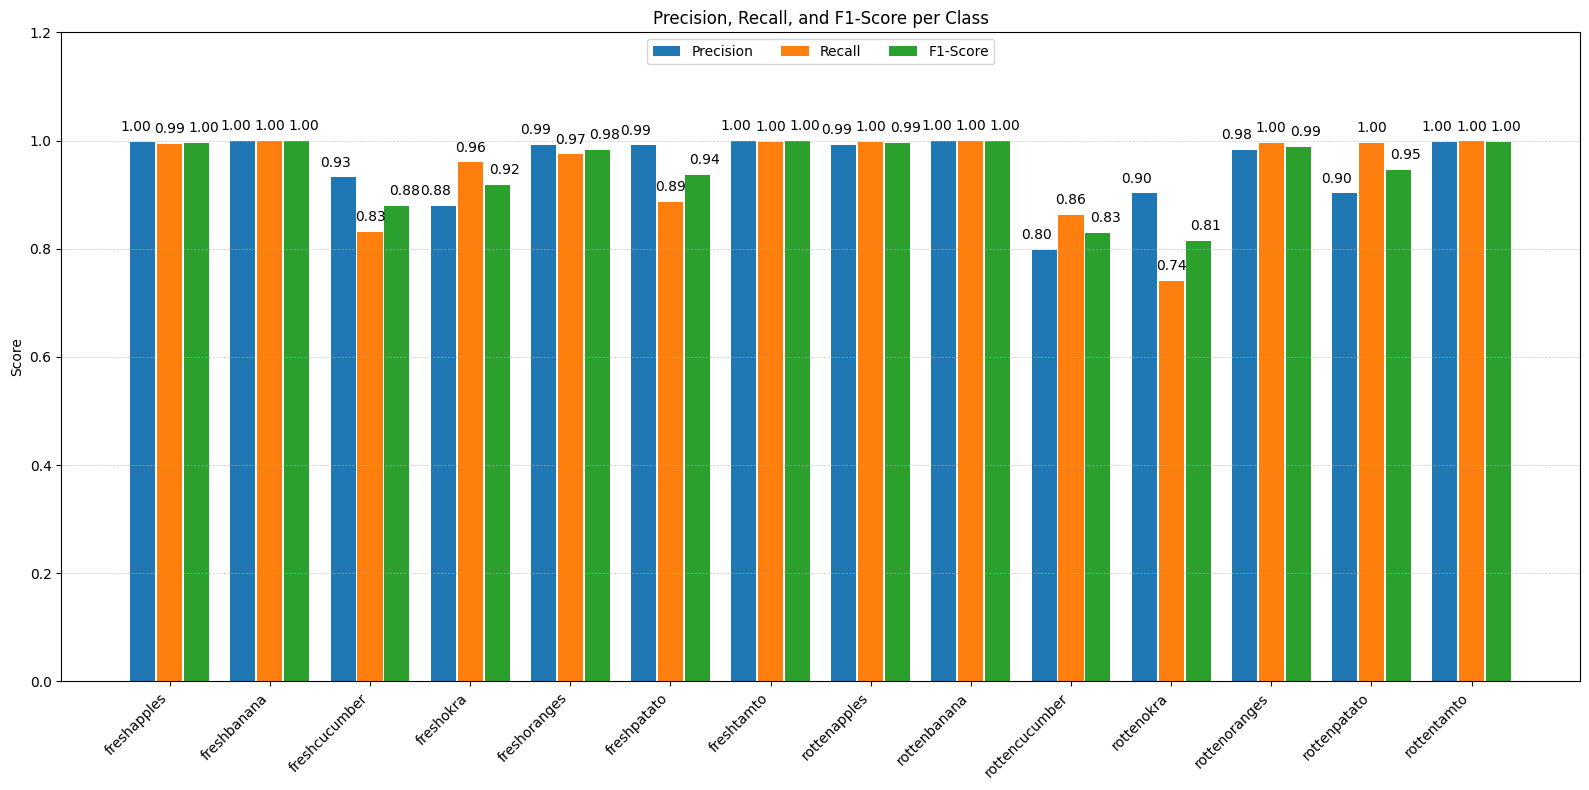

In [265]:
# --- Plot setup ---
spacing_factor = 1.6           # try values >1.0 for more gap
x = np.arange(len(target_names)) * spacing_factor
x1 = np.arange(len(target_names))

width = 0.4

fig, ax = plt.subplots(figsize=(16, 8))         # wider figure
ax.bar(x - width - 0.03, precision, width, label='Precision')
ax.bar(x ,       recall,    width, label='Recall')
ax.bar(x + width + 0.03, f1,      width, label='F1-Score')

# --- Background grid lines on y-axis ---
ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# --- Labels, ticks, legend ---
ax.set_xticks(x)
ax.set_xticklabels(target_names, rotation=45, ha='right')
ax.set_ylabel('Score')
ax.set_ylim(0, 1.2)  # ensure space above 1.0 for annotations
ax.set_title('Precision, Recall, and F1-Score per Class')
ax.legend(loc='upper center', ncol=3)

# --- Annotate each bar with its value ---
for idx in x1:
    ax.text(idx*1.6 - width - 0.15, precision[idx] + 0.02, f"{precision[idx]:.2f}", ha='center')
    ax.text(idx*1.6,       recall[idx]    + 0.02, f"{recall[idx]:.2f}",    ha='center')
    ax.text(idx*1.6 + width + 0.15, f1[idx]       + 0.02, f"{f1[idx]:.2f}",       ha='center')

plt.tight_layout()
plt.show()

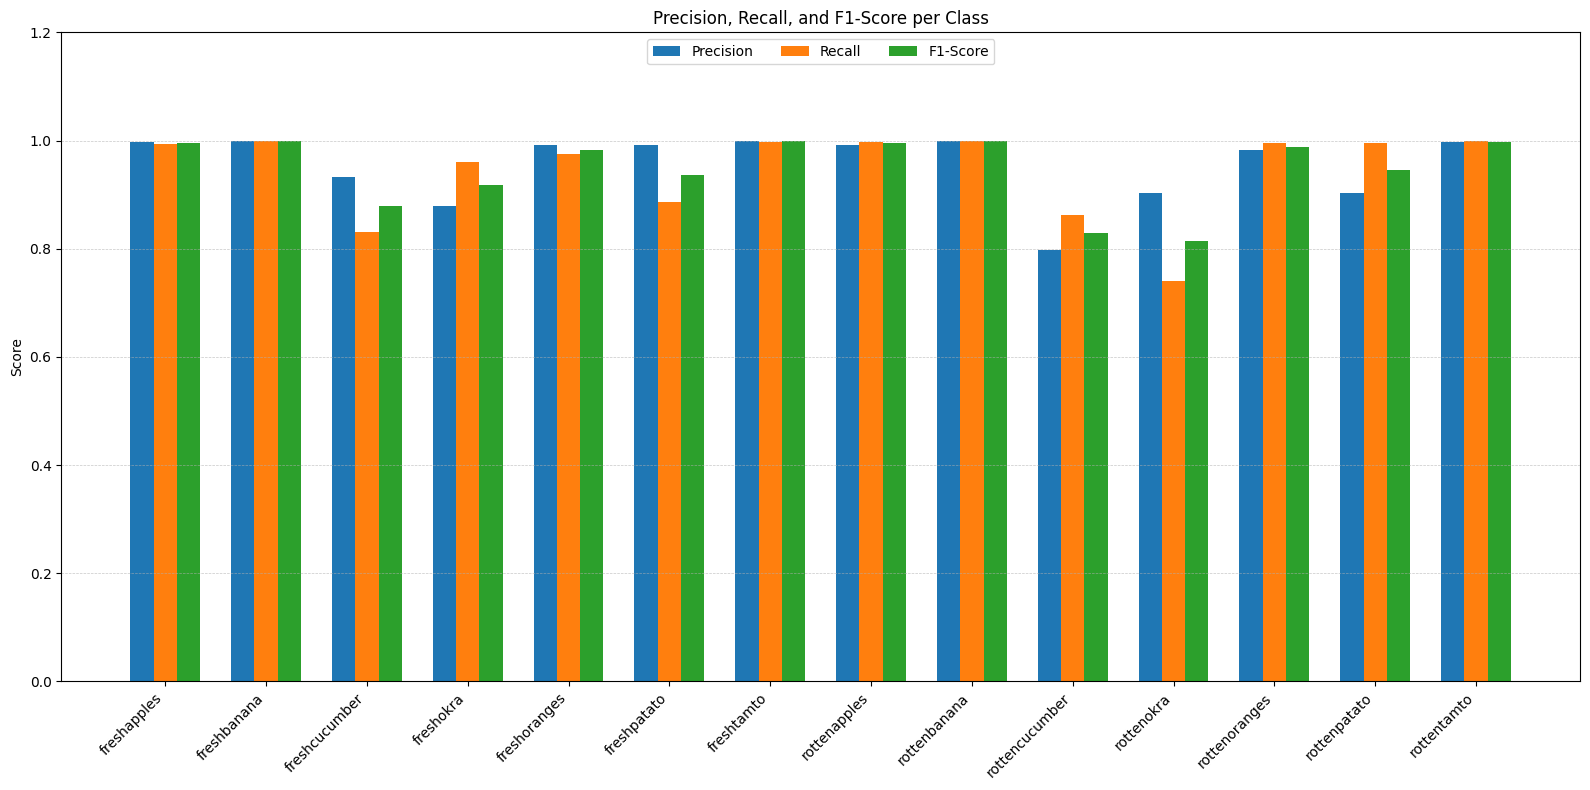

In [261]:
n_groups      = len(target_names)
bar_width     = 0.45
group_padding = 0.6    # gap between one group’s last bar and the next group’s first bar

# Compute x‑coordinates for group centers:
group_centers = np.arange(n_groups) * (3*bar_width + group_padding)

# Offsets for the three bars within each group:
offsets = [-bar_width, 0, +bar_width]

# Plot
fig, ax = plt.subplots(figsize=(16, 8))
for offset, data, label in zip(offsets, [precision, recall, f1], ['Precision','Recall','F1‑Score']):
    ax.bar(group_centers + offset, data, bar_width, label=label)

# Styling
ax.set_xticks(group_centers)
ax.set_xticklabels(target_names, rotation=45, ha='right')
ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_ylim(0, 1.2)
ax.set_ylabel('Score')
ax.set_title('Precision, Recall, and F1‑Score per Class')
ax.legend(loc='upper center', ncol=3)
plt.tight_layout()
plt.show()

In [5]:
from tensorflow.keras.models import load_model
model = load_model(
    'Res_dataset_80.keras',
    custom_objects={"LeakyReLU": LeakyReLU},
    compile=False
)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

validation_generator_all = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input
).flow_from_directory(
    'dataset/Test',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)   

Found 7927 images belonging to 14 classes.


248/248 ━━━━━━━━━━━━━━━━━━━━ 45s 181ms/step


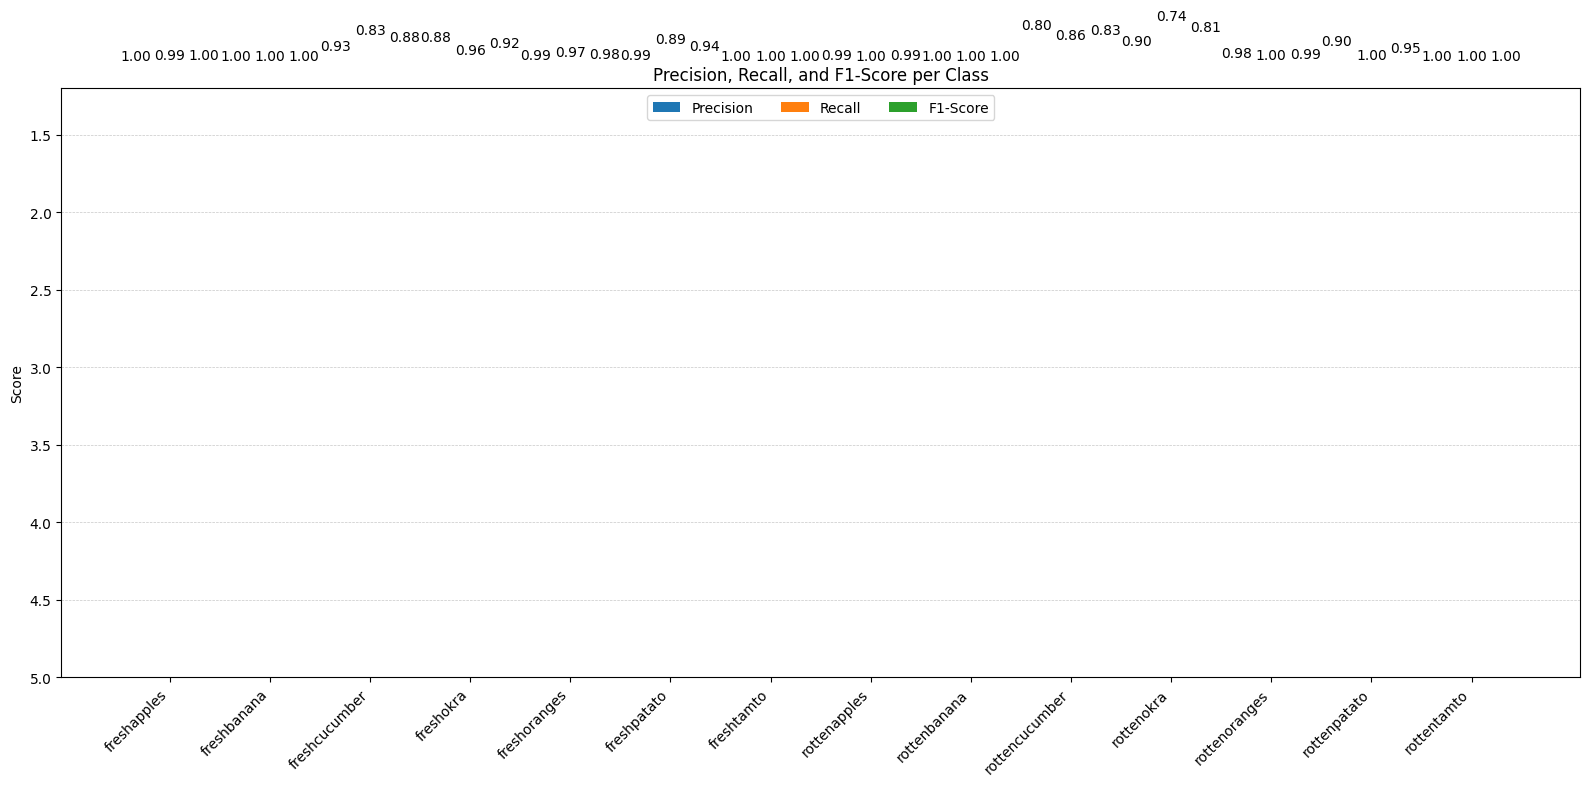

In [15]:
# Generate predictions
y_pred_probs = model.predict(validation_generator_all)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = validation_generator_all.classes  # True labels

target_names = list(validation_generator_all.class_indices.keys())

report = classification_report(
    y_true, 
    y_pred_classes, 
    target_names=target_names, 
    output_dict=True
)

# --- Extract metrics ---
precision = [report[c]['precision'] for c in target_names]
recall    = [report[c]['recall']    for c in target_names]
f1        = [report[c]['f1-score']  for c in target_names]

# --- Plot setup ---
spacing_factor = 1.6           # try values >1.0 for more gap
x = np.arange(len(target_names)) * spacing_factor
x1 = np.arange(len(target_names))

width = 0.4

fig, ax = plt.subplots(figsize=(16, 8))         # wider figure
ax.bar(x - width - 0.03, precision, width, label='Precision')
ax.bar(x ,       recall,    width, label='Recall')
ax.bar(x + width + 0.03, f1,      width, label='F1-Score')

# --- Background grid lines on y-axis ---
ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# --- Labels, ticks, legend ---
ax.set_xticks(x)
ax.set_xticklabels(target_names, rotation=45, ha='right')
ax.set_ylabel('Score')
ax.set_ylim(5, 1.2)  # ensure space above 1.0 for annotations
ax.set_title('Precision, Recall, and F1-Score per Class')
ax.legend(loc='upper center', ncol=3)

# --- Annotate each bar with its value ---
for idx in x1:
    ax.text(idx*1.6 - width - 0.15, precision[idx] + 0.02, f"{precision[idx]:.2f}", ha='center')
    ax.text(idx*1.6,       recall[idx]    + 0.02, f"{recall[idx]:.2f}",    ha='center')
    ax.text(idx*1.6 + width + 0.15, f1[idx]       + 0.02, f"{f1[idx]:.2f}",       ha='center')

plt.tight_layout()
plt.show()

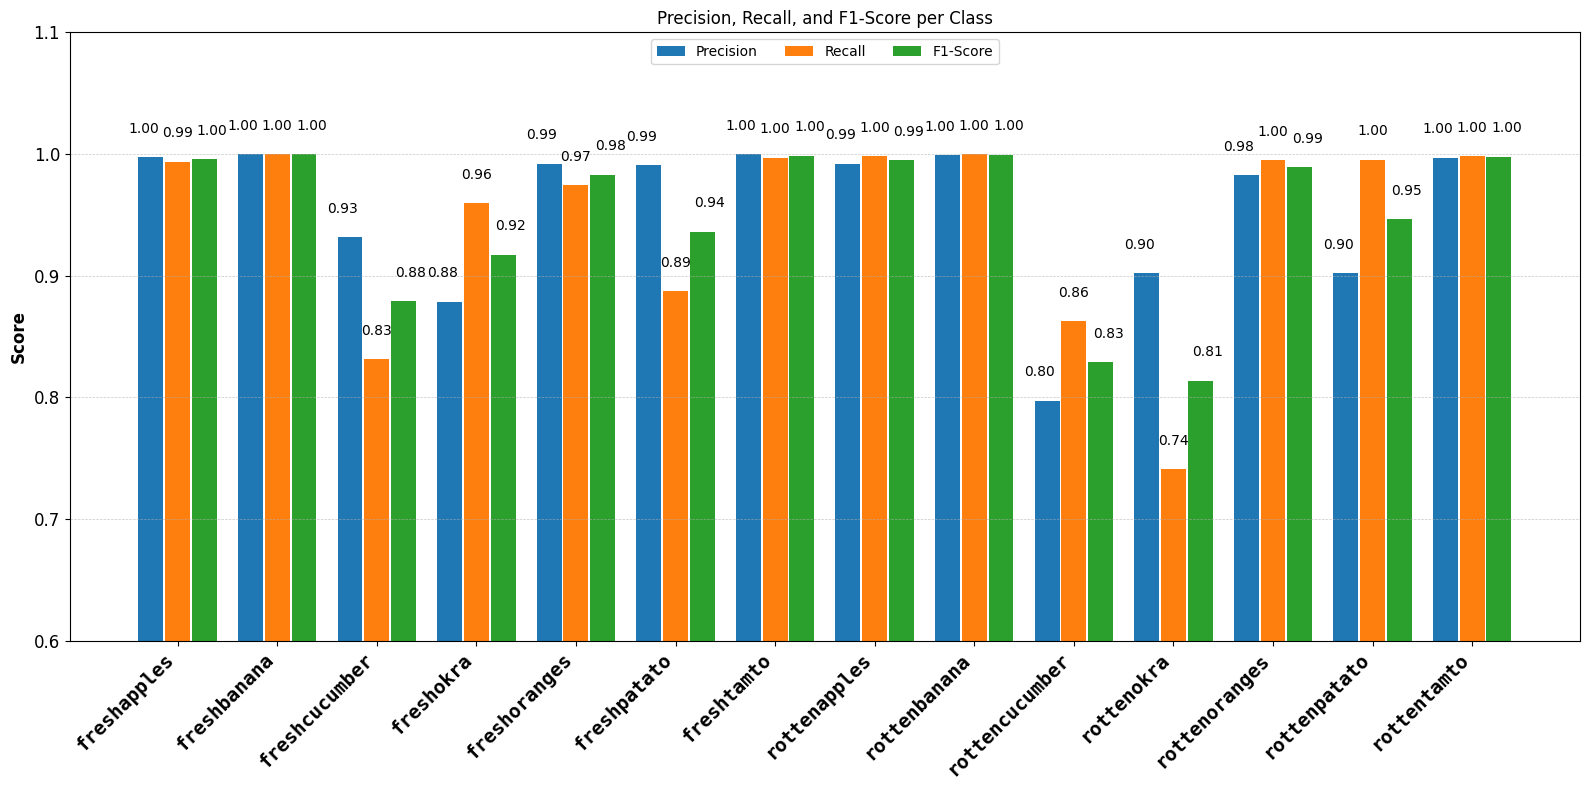

In [47]:
# --- Plot setup ---
# Set font properties
font_properties = {
    'fontsize': 14,        # Adjust size here (try 10–14)
    'fontweight': 'bold',  # Try 'normal', 'bold', or 'light'
    'fontfamily': 'monospace'  # Try 'serif', 'sans-serif', 'monospace', etc.
}
spacing_factor = 1.6           # try values >1.0 for more gap
x = np.arange(len(target_names)) * spacing_factor
x1 = np.arange(len(target_names))

width = 0.4

fig, ax = plt.subplots(figsize=(16, 8))         # wider figure
ax.bar(x - width - 0.03, precision, width, label='Precision')
ax.bar(x ,       recall,    width, label='Recall')
ax.bar(x + width + 0.03, f1,      width, label='F1-Score')

# --- Background grid lines on y-axis ---
ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# --- Labels, ticks, legend ---
ax.set_xticks(x)
ax.set_xticklabels(target_names, rotation=45, ha='right',**font_properties)
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
# Customize y-axis tick labels
ax.tick_params(axis='y', labelsize=12)
ax.set_ylim(0.6, 1.1)  # ensure space above 1.0 for annotations
ax.set_title('Precision, Recall, and F1-Score per Class')
ax.legend(loc='upper center', ncol=3)

# --- Annotate each bar with its value ---
for idx in x1:
    ax.text(idx*1.6 - width - 0.15, precision[idx] + 0.02, f"{precision[idx]:.2f}", ha='center')
    ax.text(idx*1.6,       recall[idx]    + 0.02, f"{recall[idx]:.2f}",    ha='center')
    ax.text(idx*1.6 + width + 0.15, f1[idx]       + 0.02, f"{f1[idx]:.2f}",       ha='center')

plt.tight_layout()
plt.show()

# GoogLeNET

In [272]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
).flow_from_directory(
    'All apples/Train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

valid_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(
    'All apples/Test',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)


Found 5672 images belonging to 2 classes.
Found 1779 images belonging to 2 classes.


In [276]:
pip install tensorflow-hub


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 2.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.6/252.6 MB 2.3 MB/s eta 0:00:0000:0100:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 671.4/671.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 3.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.2
    Uninstalling tensorflow-2.16.2:
      Successfully uninstalled tensorflow-2.16.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the followi

In [278]:
import tensorflow_hub as hub                                    # TF Hub API :contentReference[oaicite:1]{index=1}

# 1) Load the Inception V1 (GoogLeNet) feature‑vector module
feature_extractor = hub.KerasLayer(
    "https://tfhub.dev/google/imagenet/inception_v1/feature_vector/5",  
    input_shape=(128, 128, 3),   # adjust to match your data
    trainable=False              # freeze the pre‑trained layers
)

# 2) Attach your own classification head
model = Sequential([
    feature_extractor,
    # Fully connected layer
    Dense(128, activation=LeakyReLU(alpha=0.01)),
    Dropout(0.3),
    
    Dense(128, activation=LeakyReLU(alpha=0.01)),
    Dropout(0.3),
    
    Dense(64, activation=LeakyReLU(alpha=0.01)),
    Dropout(0.3),
    
    Dense(64, activation=LeakyReLU(alpha=0.01)),
    Dropout(0.3),
    
    # Output layer: number of neurons equals number of classes
    Dense(train_gen.num_classes, activation='softmax')
])

# 3) Compile as usual
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)




Failed to import tf_keras. Please note that tf_keras is not installed by default when you install tensorflow_hub. This is so that users can decide which tf_keras package to use. To use tensorflow_hub, please install a current version of tf_keras.




ImportError: cannot import name 'check_pinned' from 'tensorflow.python.ops.gen_experimental_dataset_ops' (/Users/milind/anaconda3/envs/gpu_env/lib/python3.11/site-packages/tensorflow/python/ops/gen_experimental_dataset_ops.py)

In [1]:
# Import necessary libraries
import tensorflow as tf
print("GPUs available:", tf.config.list_physical_devices('GPU'))

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, AveragePooling2D, Activation
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
